In [1]:
import os
import sys
import random
import warnings
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 152
IMG_HEIGHT = 60
IMG_CHANNELS = 3

TRAIN_PATH='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_train/'
TEST_PATH ='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test/'
MASK_TRAIN='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/ex_train/'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmlee\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
tf. version

<module 'tensorflow._api.v1.version' from 'C:\\Users\\jmlee\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\version\\__init__.py'>

## Train, Test

In [2]:
# #한글이름 사진 로드
from PIL import Image

#gray로 불러와야 threshold  함수 사용가능
def hangulFilePathImageRead2 (filePath ) :  
    stream = open(filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# def hangulFilePathImageRead (filePath ) :

#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_COLOR)  #3채널로 가져오기

# #train
# if __name__ == '__main__':
#     train_mask_=[]
#     train__=[]
#     for f in os.listdir(TRAIN_PATH):  
#         if f.split('.')[1] =='jpg':
#             filePath = r'C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/정맥전체(.jpg)'+'/'+f
#             train_= hangulFilePathImageRead2(filePath)  #이미지
#             train__.append(train_)
#             train_mask = cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
#             train_mask_.append(train_mask)
            
            
            
# #test
# if __name__ == '__main__':
#     test_mask_=[]
#     test__=[]
#     for f_ in os.listdir(TEST_PATH):  
#         if f_.split('.')[1] =='jpg':
#             filePath = (r"C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test"+'/'+f_)  
#             test_ = hangulFilePathImageRead2(filePath)  #이미지
#             test__.append(test_)
#             test_mask = cv2.adaptiveThreshold(test_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15)  #마스크
#             test_mask_.append(test_mask)
            
# #             print(f_)

In [3]:
# Get train and test IDs
# train_path=os.walk(TRAIN_PATH)  #agumenatation한것_에러 안남
# train_ids = next(train_path)[2]

train_path=os.walk(TRAIN_PATH) #raw
train_ids= next(train_path)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]

In [4]:
a=np.array(train_ids)
a.shape

(1300,)

In [5]:
train_ids

['[SEG]강병준_1_1.jpg',
 '[SEG]강병준_1_1_0_1862.jpg',
 '[SEG]강병준_1_1_0_2218.jpg',
 '[SEG]강병준_1_1_0_5481.jpg',
 '[SEG]강병준_1_1_0_5973.jpg',
 '[SEG]강병준_1_1_0_7302.jpg',
 '[SEG]강병준_1_1_0_764.jpg',
 '[SEG]강병준_1_1_0_7685.jpg',
 '[SEG]강병준_1_1_0_8136.jpg',
 '[SEG]강병준_1_1_0_9716.jpg',
 '[SEG]강병준_2_1.jpg',
 '[SEG]강병준_2_1_0_1632.jpg',
 '[SEG]강병준_2_1_0_331.jpg',
 '[SEG]강병준_2_1_0_3936.jpg',
 '[SEG]강병준_2_1_0_4556.jpg',
 '[SEG]강병준_2_1_0_6768.jpg',
 '[SEG]강병준_2_1_0_8011.jpg',
 '[SEG]강병준_2_1_0_8500.jpg',
 '[SEG]강병준_2_1_0_8898.jpg',
 '[SEG]강병준_2_1_0_9207.jpg',
 '[SEG]강병준_3_1.jpg',
 '[SEG]강병준_3_1_0_1277.jpg',
 '[SEG]강병준_3_1_0_1303.jpg',
 '[SEG]강병준_3_1_0_1483.jpg',
 '[SEG]강병준_3_1_0_1534.jpg',
 '[SEG]강병준_3_1_0_3253.jpg',
 '[SEG]강병준_3_1_0_3958.jpg',
 '[SEG]강병준_3_1_0_4163.jpg',
 '[SEG]강병준_3_1_0_819.jpg',
 '[SEG]강병준_3_1_0_9674.jpg',
 '[SEG]강병준_4_1.jpg',
 '[SEG]강병준_4_1_0_1587.jpg',
 '[SEG]강병준_4_1_0_2114.jpg',
 '[SEG]강병준_4_1_0_3353.jpg',
 '[SEG]강병준_4_1_0_4813.jpg',
 '[SEG]강병준_4_1_0_4843.jpg',
 '[SEG]강병준_4_1_0_4875.j

In [6]:
mask_ids

['[SEG]강병준_1_1 - 복사본 (2).jpg',
 '[SEG]강병준_1_1 - 복사본 (3).jpg',
 '[SEG]강병준_1_1 - 복사본 (4).jpg',
 '[SEG]강병준_1_1 - 복사본 (5).jpg',
 '[SEG]강병준_1_1 - 복사본 (6).jpg',
 '[SEG]강병준_1_1 - 복사본 (7).jpg',
 '[SEG]강병준_1_1 - 복사본 (8).jpg',
 '[SEG]강병준_1_1 - 복사본 (9).jpg',
 '[SEG]강병준_1_1 - 복사본.jpg',
 '[SEG]강병준_1_1.jpg',
 '[SEG]강병준_2_1  - 복사본 (2).jpg',
 '[SEG]강병준_2_1  - 복사본 (3).jpg',
 '[SEG]강병준_2_1  - 복사본 (4).jpg',
 '[SEG]강병준_2_1  - 복사본 (5).jpg',
 '[SEG]강병준_2_1  - 복사본 (6).jpg',
 '[SEG]강병준_2_1  - 복사본 (7).jpg',
 '[SEG]강병준_2_1  - 복사본 (8).jpg',
 '[SEG]강병준_2_1  - 복사본 (9).jpg',
 '[SEG]강병준_2_1  - 복사본.jpg',
 '[SEG]강병준_2_1 .jpg',
 '[SEG]강병준_3_1  - 복사본 (2).jpg',
 '[SEG]강병준_3_1  - 복사본 (3).jpg',
 '[SEG]강병준_3_1  - 복사본 (4).jpg',
 '[SEG]강병준_3_1  - 복사본 (5).jpg',
 '[SEG]강병준_3_1  - 복사본 (6).jpg',
 '[SEG]강병준_3_1  - 복사본 (7).jpg',
 '[SEG]강병준_3_1  - 복사본 (8).jpg',
 '[SEG]강병준_3_1  - 복사본 (9).jpg',
 '[SEG]강병준_3_1  - 복사본.jpg',
 '[SEG]강병준_3_1 .jpg',
 '[SEG]강병준_4_1  - 복사본 (2).jpg',
 '[SEG]강병준_4_1  - 복사본 (3).jpg',
 '[SEG]강병준_4_1  - 복사본 (4).jp

## 추출된 이미지
이진화 한 것을 mask에 저장

In [ ]:
# import cv2
# import numpy as np 
# from matplotlib import pyplot as plt 


# #gray로 불러와야 threshold  함수 사용가능
# def hangulFilePathImageRead2 (filePath ) :  
#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# img=hangulFilePathImageRead2(r'C:/Users/jmlee/Desktop/U-Net/정맥추출_train/[SEG]김보나_7_1.jpg')

# ret, th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# gaussian = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# cv2.THRESH_BINARY,15,8)

# mean1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,11, 7)

# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

# mean3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,15, 11)

# titles = ['img','gaussian','mean1','mean2','mean3']

# images = [img,gaussian,mean1,mean2,mean3]

# for i in range(5):
# 	plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
# 	plt.title(titles[i])
# 	plt.xticks([]),plt.yticks([])

# plt.show()

In [ ]:
# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

In [ ]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
a.shape # (3,4)
a.ndim # 2


In [ ]:
b = np.array([[1,2,3,4], [5,6,7,8], [9,10,11]])
b.shape # (3,)
b.ndim # 1

## 데이터 전처리

In [11]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#adaptive input은 2차원이어야함. 
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    train_= hangulFilePathImageRead2(MASK_TRAIN+id_) #2차원으로 불러오는 코드 
    mask_=cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11, 7) 
    mask_= np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    #mask = np.maximum(mask, mask_)
    Y_train[n] = mask_

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH+id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:02<00:00, 450.72it/s]

Getting and resizing test images ... 



100%|█████████████████████████████████████████████████████████████████████████████| 1161/1161 [00:04<00:00, 252.57it/s]

Done!


In [12]:
np.array(sizes_test).shape

(1161, 2)

In [13]:
X_train.shape

(1300, 60, 152, 3)

In [14]:
Y_train.shape

(1300, 60, 152, 1)

In [15]:
print(train_)

[[  0   0   0 ...   5 205 206]
 [  0   0   0 ...  16 200 195]
 [  0   0   0 ...  13  31   7]
 ...
 [ 79  80  82 ... 221 203 205]
 [ 73  80  87 ... 217 202 204]
 [ 24  21  18 ... 108 206 205]]


In [16]:
mask_.shape #3차원

(60, 152, 1)

In [17]:
img.shape  #3차원

(60, 152, 3)

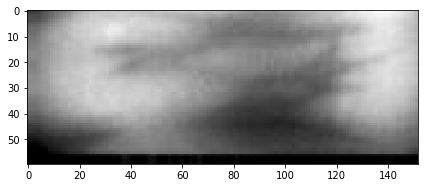

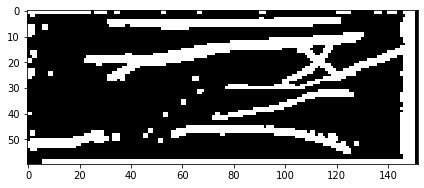

In [18]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [29]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# # Define IoU metric
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

In [30]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [31]:
s.shape

TensorShape([Dimension(None), Dimension(60), Dimension(152), Dimension(3)])

In [32]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from keras import metrics

# Build U-Net model
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
print("c1",c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
print("c1",c1)
p1 = MaxPooling2D((2, 2)) (c1)
print("p1",p1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
print("c2",c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c2",c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c3",c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3",c3)
p3 = MaxPooling2D((2, 2)) (c3)
print("p3",p3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.3) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c1])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# c9 = Dropout(0.1) (c9)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c6)
#mIOU = tf.keras.metrics.MeanIoU(num_classes=20)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("lambda_6/truediv:0", shape=(?, 60, 152, 3), dtype=float32)
c1 Tensor("conv2d_27/Elu:0", shape=(?, 60, 152, 16), dtype=float32)
c1 Tensor("conv2d_28/Elu:0", shape=(?, 60, 152, 16), dtype=float32)
p1 Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 30, 76, 16), dtype=float32)
c2 Tensor("conv2d_29/Elu:0", shape=(?, 30, 76, 32), dtype=float32)
c2 Tensor("conv2d_30/Elu:0", shape=(?, 30, 76, 32), dtype=float32)
c3 Tensor("conv2d_31/Elu:0", shape=(?, 30, 76, 64), dtype=float32)
c3 Tensor("conv2d_32/Elu:0", shape=(?, 30, 76, 64), dtype=float32)
p3 Tensor("max_pooling2d_6/MaxPool:0", shape=(?, 15, 38, 64), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 60, 152, 3)   0                                            
_____________________________________________________________

In [33]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])


Train on 1170 samples, validate on 130 samples
Epoch 1/10
1170/1170 [==============================] - 193s 165ms/step - loss: 0.5267 - mean_iou: 0.4076 - val_loss: 0.5211 - val_mean_iou: 0.4520

Epoch 00001: val_loss improved from inf to 0.52111, saving model to model-dsbowl2018-1.h5
Epoch 2/10
1170/1170 [==============================] - 193s 165ms/step - loss: 0.4627 - mean_iou: 0.4628 - val_loss: 0.5138 - val_mean_iou: 0.4696

Epoch 00002: val_loss improved from 0.52111 to 0.51383, saving model to model-dsbowl2018-1.h5
Epoch 3/10
1170/1170 [==============================] - 186s 159ms/step - loss: 0.4481 - mean_iou: 0.4737 - val_loss: 0.4969 - val_mean_iou: 0.4772

Epoch 00003: val_loss improved from 0.51383 to 0.49693, saving model to model-dsbowl2018-1.h5
Epoch 4/10
1170/1170 [==============================] - 187s 160ms/step - loss: 0.4332 - mean_iou: 0.4805 - val_loss: 0.4753 - val_mean_iou: 0.4848

Epoch 00004: val_loss improved from 0.49693 to 0.47535, saving model to model-

In [34]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

1161/1161 [==============================] - 48s 41ms/step


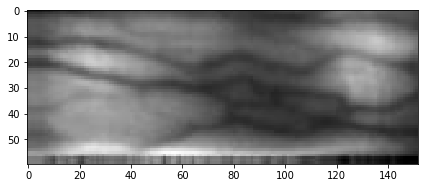

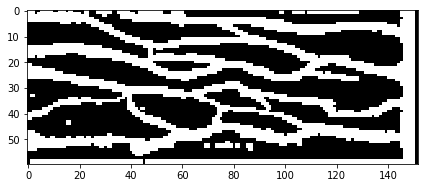

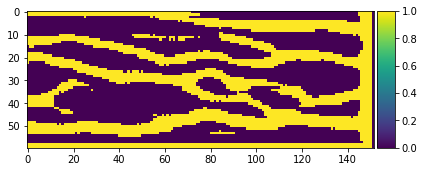

In [35]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

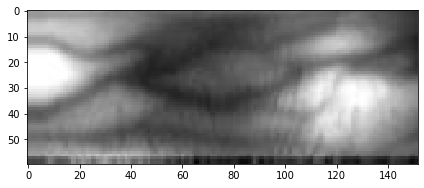

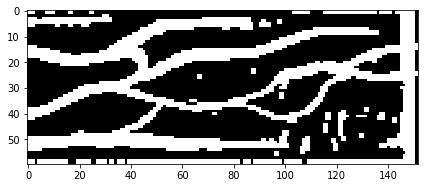

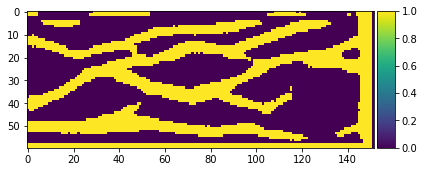

In [36]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [37]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [38]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [28]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)